# Описание проекта
Цель: оценить оригинальность ответов на задачки.

Подробное описание задачи

Пример задачки: “Как замотивировать детей носить маски?”
Пользователь должен ответить одним предложением. Идея должна быть
оригинальной, простой в реализации, “креативной”. Кстати, как бы вы
ответили?

Сейчас приложение никак не оценивает ответ пользователя, но хотелось бы
давать хоть какую-то обратную связь. Например, сказать, какой процент
пользователей сгенерировал похожую идею. Для этого мы хотим решить
задачу кластеризации текстов. То есть N ответов побить на K кластеров.
Если ваш ответ попал в один из кластеров, то можно оценить, насколько он
оригинальный по отношению размера полученного кластера к количеству
всех ответов.

## Декомпозиция

1.	Открытие данных и изучение общей информации.


2.	Предобрабработка данных

    2.1	Переименуем столбцы и посмотрим уникальные значения.
    
    2.2	В столбце 'answer' приведем все значения к нижнему регистру, и удалим лишние символы.
    
    2.3	Уберем "лишние слова" сделаем токинизацию
    
    
3.	EDA

    3.1	Посчитаем слова для кластеров
    
    3.2	Расчет кол-во ответов, соединения таблиц с кол-вом ответов и кол-вом слов
    
    3.3	Корреляционного анализа данных
    
    3.4	 График взаимосвязи ответов и кол-ва слов
    
    
4.	Кластеризация ответов

    4.1	Кластеризация ответов
    
    4.2	В среднем пользователи, оставляют не большие ответы. В среднем это 6-7 слов.



In [31]:
#pip install pymystem3

In [32]:
#pip install fasttext

In [33]:
# Импортируем нужные бибилиотеки
import pandas as pd
import numpy as np
import string
import nltk
from pymystem3 import Mystem
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score

## 1. Открытие данных и изучение общей информации.

In [34]:
data_path = 'C:\\Users\\C\\Desktop\\Shoogar\\2 маски - Разметка.csv'

df = pd.read_csv(data_path,  header=None)
display(df.head())
print('--------------------------------------------------')
print()
print(df.info())

,0,1
0,сделать маски с изображением популярных героев...,супергерой
1,набор для изготовления масок с использованием ...,рисунок
2,сделать маски с принтами животных и супергерое...,супергерой
3,детская маска и конфетка или какой-нибудь пода...,вкус
4,герой мультика или даже супергерой начал носит...,супергерой


--------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       194 non-null    object
 1   1       194 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB
None


## 2. Предобрабработка данных

### 2.1 Переименуем столбцы и посмотрим уникальные значения.

In [35]:
#Переименуем столбцы
df = df.rename(columns={0: 'answer', 1: 'cluster'})
df.head()

,answer,cluster
0,сделать маски с изображением популярных героев...,супергерой
1,набор для изготовления масок с использованием ...,рисунок
2,сделать маски с принтами животных и супергерое...,супергерой
3,детская маска и конфетка или какой-нибудь пода...,вкус
4,герой мультика или даже супергерой начал носит...,супергерой


In [36]:
# Посчитаем уникальные значения в столбце 'cluster'
print(df['cluster'].value_counts())

супергерой    55
вкус          29
рисунок       29
дизайн        21
поощрение     15
непонятно     14
технология    11
игра          10
коллекция      6
дыхание        4
Name: cluster, dtype: int64


In [37]:
# Посчитаем уникальные значения в столбце 'answer'
print(df['answer'].value_counts())

Марафон - кто дольше всех проносит маску подучит что то                                                1
персонализация в виде наклеек, аксессуаров как с кроксами                                              1
маска, на которую можно цеплять наклейки                                                               1
На масках писать регалии - самый смелый, самый ловкий, чтобы дети хотели носить маски и хвастаться.    1
Дать детям раскрасить маски друг друга                                                                 1
                                                                                                      ..
маски с запахами.                                                                                      1
Маски со вкусом и запахом                                                                              1
съедобная маска из сладкой ваты                                                                        1
Загадки на масках, чтобы все отгадывали                

#### Столбцы переименованы 'answer' - столбец с ответами, 'cluster' - столбец с кластерами .  В столбце 'cluster' 10 уникальных значений, в столбце 'answer' все значения уникальны.

### 2.2 В столбце 'answer' приведем все значения к нижнему регистру, и удалим лишние символы.

In [38]:
df['answer'] = (df['answer']
                       .str.lower()
                       .str.replace('[{}]'. format(string.punctuation), '')
                      )
df

,answer,cluster
0,сделать маски с изображением популярных героев...,супергерой
1,набор для изготовления масок с использованием ...,рисунок
2,сделать маски с принтами животных и супергерое...,супергерой
3,детская маска и конфетка или какойнибудь подар...,вкус
4,герой мультика или даже супергерой начал носит...,супергерой
...,...,...
189,маски супергероев,супергерой
190,маски с ртами и зубами животных акулий оскал ...,рисунок
191,кастомизируемые маски чтобы ребёнок мог разукр...,рисунок
192,маски которые пищат когда не надеты,технология


### 2.3 Уберем "лишнии слова" сделаем токинизацию

In [39]:
stop_words = nltk.corpus.stopwords.words('russian')

stem = nltk.stem.snowball.RussianStemmer()

dt_token = (df
                   .assign(answer = lambda x: x.answer.apply(nltk.word_tokenize))
                     .explode('answer')
                     .assign(answer = lambda x: x.answer.astype(str).apply(stem.stem))
                     .query('answer not in @stop_words')
                      )
dt_token.head()

,answer,cluster
0,сдела,супергерой
0,маск,супергерой
0,изображен,супергерой
0,популярн,супергерой
0,геро,супергерой


In [40]:

print(dt_token['answer'].value_counts())

маск          162
ил             28
сдела          27
геро           25
котор          23
             ... 
какимит         1
ткан            1
использова      1
глаз            1
потребля        1
Name: answer, Length: 545, dtype: int64


## 3. EDA

### 3.1 Посчитаем слова для кластеров

,cluster,words_cnt
0,супергерой,341
1,рисунок,172
2,дизайн,152
3,вкус,141
4,поощрение,127
5,игра,83
6,технология,77
7,непонятно,64
8,коллекция,36
9,дыхание,27


Text(0.5, 1.0, 'Кол-во слов по кластерам')

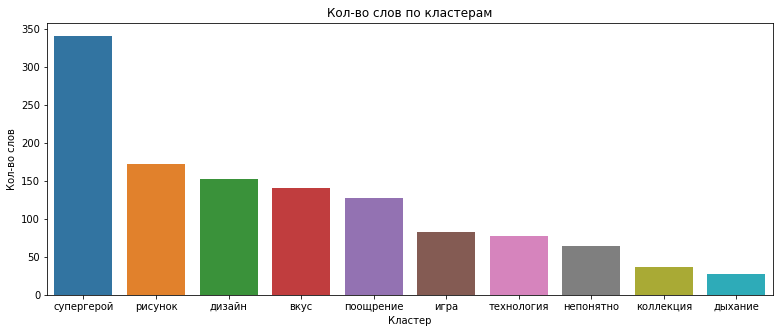

In [41]:
dt_token_cnt = (dt_token.groupby('cluster')
                .agg(words_cnt = ('answer', 'count'))
                .sort_values(by='words_cnt', ascending=False)
                .reset_index()
               )
display(dt_token_cnt)

print()
print()

#построим диаграмму распределения
plt.figure(figsize=(13,5))
sns.barplot(x='cluster', y='words_cnt', data=dt_token_cnt)
plt.ylabel('Кол-во слов')
plt.xlabel('Кластер')
plt.title('Кол-во слов по кластерам')

#### Из графика и получившийся таблицы видно, что больше всего слов в группе про супергероев, меньше всего в группе про дыхание.

### 3.2 Расчет кол-во ответов, соединения таблиц с кол-вом ответов и кол-вом слов

In [42]:
# Посчитаем кол-во ответов
df_cnt = (df.groupby('cluster')
     .agg(answer_cnt = ('answer', 'count'))
     .sort_values(by='answer_cnt', ascending=False)
     .reset_index()
    )
df_cnt

,cluster,answer_cnt
0,супергерой,55
1,вкус,29
2,рисунок,29
3,дизайн,21
4,поощрение,15
5,непонятно,14
6,технология,11
7,игра,10
8,коллекция,6
9,дыхание,4


In [43]:
#соединим таблицы с посчитами словами и ответами
dt = df_cnt.merge(dt_token_cnt, on='cluster')
display(dt)

,cluster,answer_cnt,words_cnt
0,супергерой,55,341
1,вкус,29,141
2,рисунок,29,172
3,дизайн,21,152
4,поощрение,15,127
5,непонятно,14,64
6,технология,11,77
7,игра,10,83
8,коллекция,6,36
9,дыхание,4,27


#### После соединения таблиц видно, что наиболее популярные ответы про супергероев. Они менее всего креативны

### 3.3 Корреляционного анализа данных

Text(0.5, 1, 'График корреляции')

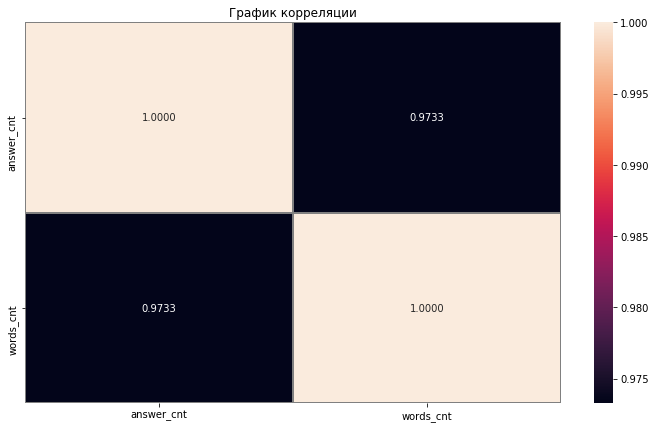

In [44]:
# Построим график корреляции.
corr_dt = dt.corr()
plt.figure(figsize=(12,7))
sns.heatmap(corr_dt, annot=True, fmt='.4f', linewidths=1, linecolor='gray')
plt.title('График корреляции')

#### Среди данных наблюдаетс полная зависимость, чем больше ответов тем больше слов и наоборот.

### 3.4 График взаимосвязи ответов и кол-ва слов 

Text(0.5, 1.0, 'Взаимосвязь ответов и кол-ва слов')

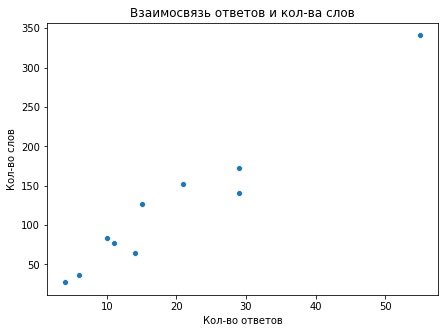

In [45]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='answer_cnt', y='words_cnt', data=dt)
plt.ylabel('Кол-во слов')
plt.xlabel('Кол-во ответов')
plt.title('Взаимосвязь ответов и кол-ва слов')

In [46]:
#посчитаем сколько в среднем слов пишут пользователи в каждом кластере. 
dt['word_1_answer'] = round(dt['words_cnt'] / dt['answer_cnt'], 2)

dt

,cluster,answer_cnt,words_cnt,word_1_answer
0,супергерой,55,341,6.20
1,вкус,29,141,4.86
2,рисунок,29,172,5.93
3,дизайн,21,152,7.24
4,поощрение,15,127,8.47
5,непонятно,14,64,4.57
6,технология,11,77,7.00
7,игра,10,83,8.30
8,коллекция,6,36,6.00
9,дыхание,4,27,6.75


Среди данных наблюдается  полная корреляционная зависимость, чем больше ответов тем больше слов и наоборот. 

После соединения таблиц видно, что наиболее популярные ответы про супергероев. 

Из графика и получившийся таблицы видно, что самый популярный ответ по кол-ву слов это ответ про супергероев, не популярный про дыхание.


## 3.5 Посчитаем популярные слова для каждого кластера.

In [47]:
# Функци разделени на кластера иподсчета популярных слов в кластерах
def popular_words(table, q, a, z):
        dt_su = table[table[q] == a]      #table.query('q == "a"')
        dt_su_cnt = dt_su.groupby([z]).agg(answer_cnt = (z, 'count')).reset_index()
                 
        pop_word = dt_su_cnt.sort_values(by='answer_cnt', ascending=False)
        print()
        print('Таблица популярных слов для кластера: ', a)
        display(pop_word.head())
        print()
        print('Слова входящие в кластер: ', a)
        print()
        print(dt_su['answer'].unique())

In [48]:
#Воспользуемся, создано функцией для подсчетов.
cluster_unique = dt_token['cluster'].unique()
for i in cluster_unique:
    popular_words(dt_token, 'cluster', i, 'answer')


Таблица популярных слов для кластера:  супергерой


,answer,answer_cnt
63,маск,45
14,геро,25
132,супергеро,16
59,любим,11
117,сдела,11



Слова входящие в кластер:  супергерой

['сдела' 'маск' 'изображен' 'популярн' 'геро' 'массов' 'культур' 'принт'
 'животн' 'супергеро' 'любим' 'мультик' 'гер' 'ил' 'даж' 'супергер' 'нача'
 'нос' 'должн' 'составля' 'коллекц' 'изобража' 'современ' 'мультфильм'
 'разн' 'цвет' 'тд' 'родител' 'дет' 'парн' 'персонаж' 'пиш' 'надева'
 'виля' 'тольк' 'друг' 'начина' 'угадыва' 'раскрас' 'паттерн' 'специальн'
 'сер' 'надел' 'стал' 'динозавр' 'супермен' 'придума' 'атрибут' 'образ'
 'мульт' 'киногеро' 'част' 'костюм' 'игров' 'нарисова' 'рожиц' 'звер'
 'мордочк' 'морд' 'классн' 'надпис' 'заклинан' 'котор' 'дают' 'суперсил'
 'известн' 'детск' 'одева' 'подражан' 'супер' 'героевз' 'ношен' 'проверя'
 'ребенка' 'форм' 'игр' 'молчанк' 'предлага' 'раскрашен'
 'динозавровтрансформер' 'мальчик' 'фильм' 'комикс' 'созда' 'уникальн'
 'рисова' 'ребенк' 'щек' 'какогонибуд' 'мил' 'ем' 'нужн' 'прикрыва'
 'одеялк' 'заботлив' 'скрыва' 'посторон' 'глаз' 'дорисовыва' 'всем'
 'компьютерн' 'мобильн' 'халк' 'капита' 'амер

,answer,answer_cnt
40,маск,25
82,сдела,7
24,ил,6
34,котор,5
16,животн,5



Слова входящие в кластер:  рисунок

['набор' 'изготовлен' 'масок' 'использован' 'подходя' 'материал' 'маск'
 'нос' 'ус' 'бород' 'представля' 'соб' 'дел' 'котор' 'можн' 'цепля'
 'наклейк' 'рисова' 'дет' 'разрисовыва' 'могл' 'рассказа' 'сво' 'настроен'
 'состоян' 'ребенок' 'созда' 'дизайн' 'рисунок' 'цвет' 'завязок' 'повышен'
 'температур' 'ил' 'появля' 'надписьсюрприз' 'нарисова' 'зуб' 'клык'
 'мордочк' 'животн' 'разукрас' 'прикольн' 'принт' 'сдела' 'сегодняшн'
 'какимит' 'рожиц' 'ля' 'зайчик' 'котик' 'итд' 'дат' 'кажд' 'разработа'
 'себ' 'сем' 'пуст' 'расписыва' 'раскрас' 'друг' 'дела' 'вид' 'мастер'
 'класс' 'создан' 'собствен' 'игр' 'дух' 'тамогоч' 'домашн' 'персонализац'
 'наклеек' 'аксессуар' 'крокс' 'возможн' 'рисунк' 'ник' 'соц' 'сет' 'тд'
 'ярк' 'разн' 'зависим' 'времен' 'суток' 'специальн' 'детск' 'картинк'
 'написа' 'надет' 'смайликамиэмоц' 'любим' 'персонаж' 'ртам' 'акул' 'оска'
 'львин' 'зев' 'кастомизируем' 'мог' 'мам' 'вкус']

Таблица популярных слов для кластера:  вкус


,answer,answer_cnt
36,маск,23
19,запах,6
65,съедобн,4
55,разн,4
26,конфет,4



Слова входящие в кластер:  вкус

['детск' 'маск' 'конфетк' 'ил' 'какойнибуд' 'подарок' 'набор' 'запах'
 'съедобн' 'макс' 'котор' 'можн' 'лиза' 'изнутр' 'леденец' 'любим' 'вкус'
 'сладк' 'ват' 'зап' 'разн' 'вкусн' 'соск' 'пахнет' 'облизыва' 'чтот'
 'обратн' 'сторон' 'морожен' 'конфет' 'наград' 'правд' 'нос' 'пахнут'
 'шоколад' 'друг' 'вкусняшк' 'леденц' 'посл' 'рассасыван' 'грызеш'
 'пластиков' 'трубочк' 'пропита' 'какимт' 'приятн' 'аромат' 'конфетн'
 'жвачн' 'всегд' 'пахл' 'кажд' 'выдава' 'ребенк' 'аксессуар' 'игрушк'
 'сладост' 'встроен' 'совс' 'маленьк' 'сахар' 'внутр' 'сдела' 'маскасоск'
 'добав' 'тип' 'чупачупч' 'жвачк' 'вкусомзапах' 'пропитк' 'фрукт' 'выпечк'
 'чупачупс']

Таблица популярных слов для кластера:  непонятно


,answer,answer_cnt
21,маск,5
34,показа,3
29,нос,3
9,дет,2
0,бабушкидедушк,1



Слова входящие в кластер:  непонятно

['нос' 'шлем' 'вмест' 'маск' 'протюнингова' 'напуга' 'ребенк' 'показа'
 'страшн' 'вирус' 'заползт' 'рот' 'ил' 'внутр' 'дет' 'эт' 'стильн'
 'выпуст' 'ролик' 'лидер' 'мнен' 'опасн' 'ношен' 'заболевш' 'родител'
 'бабушкидедушк' 'сдела' 'комикс' 'масок' 'сер' 'постав' 'всем' 'брекет'
 'снят' 'эпизод' 'условн' 'маш' 'медвед' 'нужн' 'отбав' 'какойт'
 'дополнительн' 'элемент' 'маскашл' 'маскатрансформер' 'придумыва' 'разн'
 'задан' 'кажд' 'ден' 'рекламн' 'кампан' 'тв' 'детск' 'вообщ']

Таблица популярных слов для кластера:  дыхание


,answer,answer_cnt
11,маск,3
4,дыхан,3
5,ег,2
12,музык,1
20,таймер,1



Слова входящие в кластер:  дыхание

['маск' 'картинк' 'изнутр' 'котор' 'показыва' 'есл' 'подыша' 'какоет'
 'врем' 'подсветк' 'дыхан' 'таймер' 'активируем' 'встроен' 'наушник'
 'счет' 'ег' 'темп' 'активн' 'получа' 'собствен' 'музык']

Таблица популярных слов для кластера:  игра


,answer,answer_cnt
29,маск,10
19,игр,7
20,игра,4
32,можн,3
50,спец,2



Слова входящие в кластер:  игра

['продава' 'маск' 'сраз' 'вмест' 'правил' 'нов' 'игр' 'котор' 'можн'
 'игра' 'двор' 'рисова' 'пот' 'угада' 'спец' 'агент' 'надел' 'задан' 'пр'
 'загадк' '«' '»' 'нужн' 'вопрос' 'теб' 'надет' 'лиц' 'сдела' 'модул'
 'управлен' 'камер' 'устройств' 'фиксир' 'зависим' 'движен' 'голов'
 'выполня' 'действ' 'детьм' 'дольш' 'пробудет' 'какойт' 'приз' 'вруча'
 'част' 'долг' 'ношен' 'интегрирова' 'компьютерн' 'популярн' 'дет'
 'придума' 'игруинтеракт' 'ил' 'мастеркласс' 'показа' 'мультфильм' 'стил'
 'валл']

Таблица популярных слов для кластера:  поощрение


,answer,answer_cnt
35,маск,13
57,получа,5
2,балл,4
12,дет,3
37,масок,3



Слова входящие в кластер:  поощрение

['чекин' 'маск' 'инстагр' 'получа' 'дополнительн' 'лайк' 'балл' 'нос'
 'метр' 'ил' 'магазин' 'пот' 'накоплен' 'чтот' 'интересн' 'весел'
 'маскастатус' 'набор' 'масок' 'выбор' 'эмоциипос' 'хотел' 'сказа'
 'придума' 'счетчик' 'котор' 'счита' 'скольк' 'минут' 'лиц' 'сист'
 'поощрен' 'конкурс' 'ношен' 'писа' 'регал' 'смел' 'ловк' 'дет' 'хваста'
 'дава' 'скидк' 'столов' 'марафон' 'дольш' 'пронос' 'подуч' 'сдела'
 'тикток' 'больш' 'охват' 'урок' 'одн' 'домашн' 'задан' 'меньш' 'дела'
 'селф' 'коп' 'можн' 'обменя' '1' 'ден' 'каникул' 'провест' 'прост'
 'понятн' 'лекц' 'дат' 'поня' 'зач' 'нужн' 'рассказа' 'истор' 'эт' 'наш'
 'щит' 'бактер' 'объясня' 'е' 'польз' 'обеща' 'маленьк' 'человек'
 'вознагражден' 'применен' 'положен' 'мест' 'соревнован' 'синхронизирующ'
 'приложен' 'шевел' 'бровямимаскойгуб' 'игр' 'убегаешьспаса' 'прикольн']

Таблица популярных слов для кластера:  технология


,answer,answer_cnt
21,маск,11
20,котор,3
10,дополнен,2
58,экра,2
1,вид,2



Слова входящие в кластер:  технология

['одноразов' 'маск' 'сюрприз' 'внутр' 'экра' 'дополнен' 'реальност'
 'срабатыва' 'тольк' 'есл' 'ребенок' 'придума' 'постав' 'город' 'ил'
 'датчик' 'котор' 'считыва' 'тво' 'пот' 'премир' 'е' 'ношен' 'конструктор'
 'вмест' 'клапа' 'установл' 'модулятор' 'голос' 'цвет' 'хамелеон' 'друг'
 'навод' 'телефон' 'вид' 'человек' 'дурн' 'образ' 'показа' 'бактер'
 'возможн' 'избежа' 'помощ' 'необычн' 'способ' 'получен' 'масок' 'стреля'
 'пистолет' 'скатыва' 'горк' '—' 'теб' 'налета' 'спуст' 'сколькот'
 'времен' 'пищат' 'когд' 'надет']

Таблица популярных слов для кластера:  коллекция


,answer,answer_cnt
12,маск,4
22,тематическ,2
20,собра,2
9,коллекц,2
10,коллекцион,2



Слова входящие в кластер:  коллекция

['маск' 'хобб' 'коллекционирован' 'пак' 'альб' 'стикер' 'собра'
 'коллекцион' 'тематическ' 'набор' 'масок' 'кажд' 'ден' 'ест' '1' '2' '3'
 'уровн' 'можеш' 'след' 'уровен' 'получ' 'тольк' 'выполн' 'ряд' 'услов'
 'коллекц' 'когд']

Таблица популярных слов для кластера:  дизайн


,answer,answer_cnt
41,маск,23
34,котор,4
26,ил,4
78,сдела,3
56,например,3



Слова входящие в кластер:  дизайн

['сдела' 'е' 'имен' 'загадк' 'маск' 'отгадыва' 'голов' 'дет' 'лет' '1213'
 'модн' 'бренд' 'набор' 'идет' 'например' 'силиконов' 'браслет' 'цвет'
 'настроен' 'кажд' 'выбира' 'эмоц' 'котор' 'ощуща' 'нош' 'маскуизуча'
 'мам' 'пап' 'выпуст' 'принт' 'назван' 'игр' 'популярн' 'блогер' 'тикток'
 'тд' 'мультфильм' 'смешн' 'надпис' 'стекл' 'магазин' 'обществен'
 'транспорт' 'везд' 'нужн' 'нос' 'нарисова' 'элемент' 'будут' 'дополня'
 'медицинск' 'автограф' 'звезд' 'дела' 'стил' 'рюкзак' 'тип' 'комплект'
 'семейн' 'коллаборац' 'маскаочк' 'масканаушник' 'шуточн' 'бород'
 'мальчик' 'мейкон' 'девочек' 'ярк' 'скольк' 'дне' 'теб' 'эт' 'ил' 'тво'
 'инстагр' 'визиткатикток' 'логотип' 'можеш' 'придума' 'программ' 'шаблон'
 'показа' 'возможн' 'ткан' 'особ' 'лук' 'каза' 'чужеродн' 'наоборот'
 'пойт' 'вообщ' 'друг' 'сторон' 'челендж' 'использова' 'надева' 'стран'
 'предмет' 'одинаков' 'член' 'сем' 'ребенок' 'привык' 'меньш' 'беспоко']


Во всех групах популярное слово это - маска и его одокоренные слова.

## 4 Кластеризация ответов

### 4.1 Кластрезация ответов

Для того, чтобы приступить к кластеризации, необходимо представить текст ввиде векторов.

In [49]:
# представим текст столбцов в виде векторов
from sklearn.feature_extraction.text import HashingVectorizer
vectorizer = HashingVectorizer()
pre = vectorizer.fit_transform(df['answer'])
true = vectorizer.fit_transform(df['cluster'])


Так как слова могут отличаться по окончанию, то они буду в целом подобны. Выбираем кол-во соседей (подобных слов к кол-ве 20 штук)

In [87]:
#найдем подоные вектора
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=20)
pred_1 = neigh.fit(pre)
pred = neigh.kneighbors_graph(pre)

#### Выберем для кластеризации метод k_means. Т.к. есть уже ручная кластеризация и нам извесно кол-во кластеров, тогда возьмем кол-во кластеров равных кол-ву уникальных значений в столбце cluster. Это необходимо для того, чтобы кол-во кластеров совпадало при ручной и машинной разбивке. И V-мерой сравнивать подобные столбцы.

In [88]:
# задаём модель k_means
# число кластеров будем барть по кол-ву уникальных значений в столбце "cluster"
n = df['cluster'].nunique() # считаем кол-во уникальных значений в столбцк cluster
sc = StandardScaler(with_mean=False)
pred_sc = sc.fit_transform(pred)

km = KMeans(n_clusters = n, random_state=0)
labels_pred = km.fit_predict(pred_sc)
df['labels_pred'] = labels_pred
display(df.head())
print('----------------------------------------------')
print(df['labels_pred'].value_counts())

,answer,cluster,labels_pred,labels_true
0,сделать маски с изображением популярных героев...,супергерой,9,2
1,набор для изготовления масок с использованием ...,рисунок,8,1
2,сделать маски с принтами животных и супергерое...,супергерой,9,2
3,детская маска и конфетка или какойнибудь подар...,вкус,1,0
4,герой мультика или даже супергерой начал носит...,супергерой,4,2


----------------------------------------------
2    61
1    29
9    28
3    20
4    18
0    10
7     8
6     8
8     7
5     5
Name: labels_pred, dtype: int64


#### Столбец 'cluster' это ручная кластеризация ответов, возьмем его для сравнения со столбцом labels_pred. Для начала столбец cluster тоже кластерезуем методом k_means. (Делаю для удобства, чтобы сделать цифровой столбец)

In [79]:
# задаём модель k_means с числом кластеров 10
sc = StandardScaler(with_mean=False)
true_sc = sc.fit_transform(true)

km = KMeans(n_clusters = n, random_state=0)
labels_true = km.fit_predict(true_sc)
df['labels_true'] = labels_true
display(df.head())
print('----------------------------------------------')
print(df['labels_true'].value_counts())

,answer,cluster,labels_pred,labels_true
0,сделать маски с изображением популярных героев...,супергерой,9,2
1,набор для изготовления масок с использованием ...,рисунок,8,1
2,сделать маски с принтами животных и супергерое...,супергерой,9,2
3,детская маска и конфетка или какойнибудь подар...,вкус,1,0
4,герой мультика или даже супергерой начал носит...,супергерой,4,2


----------------------------------------------
2    55
1    29
0    29
3    21
6    15
4    14
5    11
7    10
8     6
9     4
Name: labels_true, dtype: int64


### 4.2 Оценим качество кластеризации V - мерой

In [86]:
print('v_measure_score = ', round(v_measure_score(df['labels_true'], df['labels_pred']), 2))

v_measure_score =  0.1


### 4.3 Оценим ответ пользователя

In [54]:
# посчитаем процент ответивших пользователей согласно кластеризации
pred_group = (df.groupby(['labels_pred'])
              .agg(pred_cnt = ('labels_pred', 'count')).reset_index()
              .sort_values(by='pred_cnt', ascending=False)
             )
pred_group['answer_percent'] = round(pred_group['pred_cnt'] / df['labels_pred'].count() * 100, 2)

# Функция для оценки ответа пользователя

def func(row):
    if row['answer_percent'] <= 4:
        return 'Ваш ответ креативный'
    elif 4 < row['answer_percent'] <= 11:
        return 'Ваш ответ обычный' 
    else:
        return 'Ваш ответ не креативный'

# Проверим работу функции

pred_group['message'] = pred_group.apply(func, axis=1)
pred_group

,labels_pred,pred_cnt,answer_percent,message
2,2,61,31.44,Ваш ответ не креативный
1,1,29,14.95,Ваш ответ не креативный
9,9,28,14.43,Ваш ответ не креативный
3,3,20,10.31,Ваш ответ обычный
4,4,18,9.28,Ваш ответ обычный
0,0,10,5.15,Ваш ответ обычный
6,6,8,4.12,Ваш ответ обычный
7,7,8,4.12,Ваш ответ обычный
8,8,7,3.61,Ваш ответ креативный
5,5,5,2.58,Ваш ответ креативный


In [55]:
#соединим таблицы, получим таблицу с оценками креативности ответа.

df_final = df.merge(pred_group, on='labels_pred')
df_final.head()

,answer,cluster,labels_pred,labels_true,pred_cnt,answer_percent,message
0,сделать маски с изображением популярных героев...,супергерой,9,2,28,14.43,Ваш ответ не креативный
1,сделать маски с принтами животных и супергерое...,супергерой,9,2,28,14.43,Ваш ответ не креативный
2,маски с картинками изнутри которые показываютс...,дыхание,9,9,28,14.43,Ваш ответ не креативный
3,пишем на маски персонажей дети надевают и виля...,супергерой,9,2,28,14.43,Ваш ответ не креативный
4,подсветка от дыхания,дыхание,9,9,28,14.43,Ваш ответ не креативный



## Общий вывод

Методом K_means сделана кластеризация, таблица разбита на 10 кластеров. Метрика v_measure_score = 0.10. Кластеризация и столбец схожи на 10%. В кластере 3 и 8 столбцы labels_pred ответов  всего 2 и 1 соответственно, следовательно можно предположить, что это наиболее редкий и не популярный ответ на поставленный вопрос и он же будет являтся креативным.

В среднем пользователи, оставлют не большие ответы. Среднее число слов в ответе: 6-7.